<a href="https://colab.research.google.com/github/MehrdadJalali-AI/GAN-MOF/blob/main/GAN_NodeGeneration_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-fbc51fbe2a79>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  data = torch.tensor(list(features.values()), dtype=torch.float32)


Epoch [200/1000], D Loss: 1.3098905086517334, G Loss: 0.627571165561676
Epoch [400/1000], D Loss: 1.3806941509246826, G Loss: 0.6827486753463745
Epoch [600/1000], D Loss: 1.4123904705047607, G Loss: 0.6548818349838257
Epoch [800/1000], D Loss: 1.2327566146850586, G Loss: 1.0687459707260132
Epoch [1000/1000], D Loss: 1.137882947921753, G Loss: 0.7267500162124634


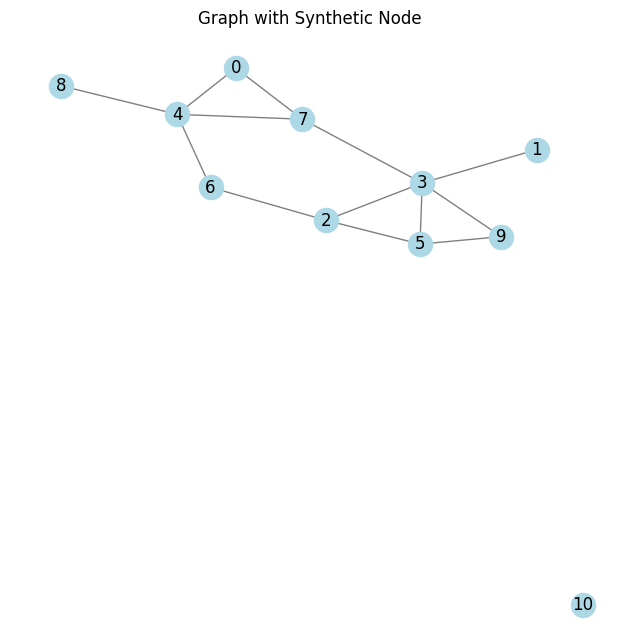

New synthetic node 10 generated with features: [0.01661193 0.57425654]


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a simple graph
graph = nx.erdos_renyi_graph(n=10, p=0.3)  # 10 nodes, probability 0.3 for edges
features = {node: np.random.rand(2) for node in graph.nodes}  # Random 2D features

# Convert features to tensor
data = torch.tensor(list(features.values()), dtype=torch.float32)

# Step 2: Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
input_dim = 2  # Feature size
z_dim = 2      # Noise size
generator = Generator(z_dim, input_dim)
discriminator = Discriminator(input_dim)

# Optimizers
lr = 0.01
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Train Discriminator
    real_labels = torch.ones(data.shape[0], 1)
    fake_labels = torch.zeros(data.shape[0], 1)

    # Real data loss
    d_optimizer.zero_grad()
    real_loss = criterion(discriminator(data), real_labels)

    # Fake data loss
    z = torch.randn(data.shape[0], z_dim)
    fake_data = generator(z)
    fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    # Train Generator
    g_optimizer.zero_grad()
    g_loss = criterion(discriminator(fake_data), real_labels)
    g_loss.backward()
    g_optimizer.step()

    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Generate synthetic node feature
z = torch.randn(1, z_dim)
new_node_feature = generator(z).detach().numpy()[0]

# Step 3: Add the synthetic node to the graph
new_node = max(graph.nodes) + 1
graph.add_node(new_node)
features[new_node] = new_node_feature

# Visualizing the graph
plt.figure(figsize=(6,6))
nx.draw(graph, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Graph with Synthetic Node")
plt.show()

print(f"New synthetic node {new_node} generated with features: {new_node_feature}")
